# Sampling in 1D energy landscape
In this notebook we will define a simple 1D potential energy surface using $V(x)=cos(x)$ over the range $[-4\pi, 4\pi]$. The notebook contains the following steps:
1. Numerical calculation of average energy, entropy and free energy to define the ground truth.
2. Langevin dynamics starting from one local minimum
3. Calculation of density from MD frames as well as therodynamic quantities (average energy, entropy, free energy)
4. Convergence study for thermodynamic quantities

In [17]:
import ensembler

import numpy as np
from matplotlib import pyplot as plt

##Ensembler
from ensembler.potentials import OneD as potentials1D
from ensembler.potentials import TwoD as potentials2D

import ensembler.visualisation.plotPotentials as vis

from ensembler.samplers.stochastic import langevinIntegrator
from ensembler.system import system
from ensembler.visualisation.plotSimulations import oneD_simulation_analysis_plot
from ensembler.conditions.box_conditions import periodicBoundaryCondition


### Settings for defining the potential and subsequent analysis

In [18]:
min_x = -4*np.pi
max_x = 4*np.pi

amplitude = 1

multiplicit = 1

temperature = 1.0

###Plotting & energy evaluations:
#params
extent = (min_x,max_x)
box_length = max_x - min_x

test_timing_with_points = 1000

### Defintion of potential:
1D cosine function between $-4\pi$ and $4\pi$ 

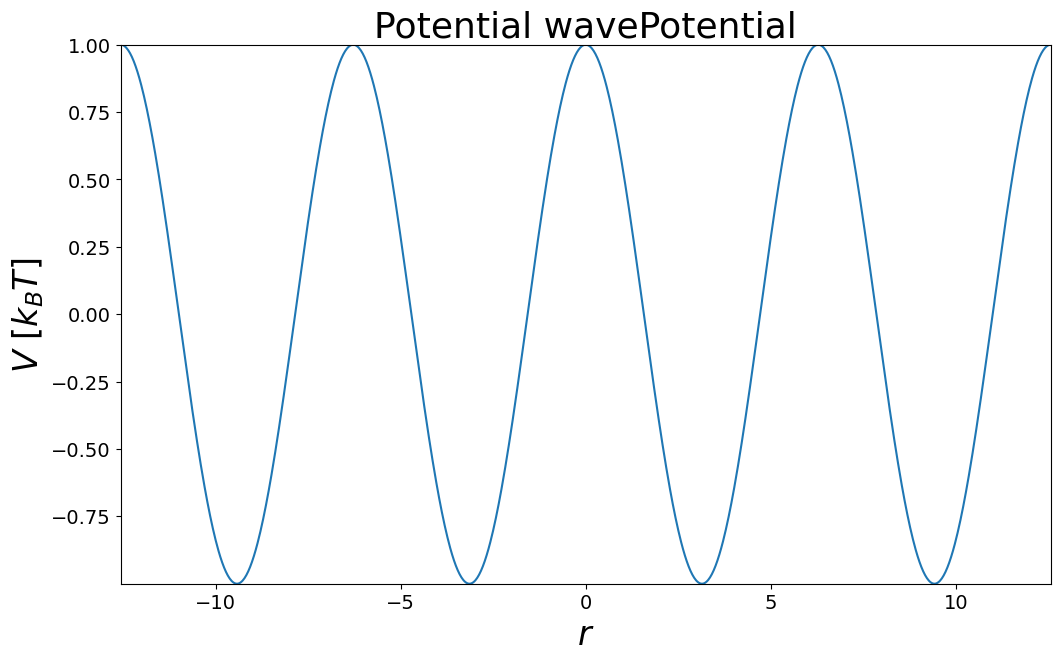

In [19]:
#1D
positions = np.linspace(min_x, max_x, test_timing_with_points)

V = potentials1D.wavePotential(amplitude=amplitude, radians=True, multiplicity=multiplicit, y_shift=0.0)
#print(V)

fig, axes = vis.plot_1DPotential_V(V, positions=positions)

### Function to compute potential energy in 1D for discrete points in defined interval

In [20]:
def sample_energy_1D(energy, extent=extent, resolution=test_timing_with_points, dim=1):
    xs = np.linspace(*extent, resolution)
    us = energy.ene(xs)

    return us

### Function to compute thermodynamic quantities by numerical integration over discrete points in defined interval

In [21]:
def compute_stats(energy, slice_width, dim=2):
    dx = np.power([slice_width], dim)
    
    boltz = np.exp(-energy/temperature)

    Z = np.sum(boltz)*dx
    prob = boltz/Z

    av_en = np.sum(prob*energy)*dx
    #print(prob.max())
    prob_pos = prob[np.where(prob>0.0001*dx)]
    #print(prob_pos)
    TS = -temperature*np.sum(prob_pos*np.log(prob_pos))*dx
    fe = -temperature*np.log(Z)

    print("Average energy : %.3f" % av_en)
    print("Entropy        : %.3f" % TS)
    print("Free energy    : %.3f" % fe)
    
    return prob, fe, av_en, TS

### Compute thermodynamic values for potential
We will now compute the potential energy $V(x)$ over discrete points and then compute the thermodynamic quantities using statistical mechanics:
* Average energy: $<E>=\sum_x p(x) V(x) dx$
* Free energy   : $F = -k_B T ln(Z)$ with $Z=\sum_x exp(-V(x)/k_B T) dx$
* Entropy       : $TS = -k_B T \sum_x p(x) ln(p(x)) dx$

In [16]:
en1 = sample_energy_1D(V, dim=1)
slice_width = (box_length/test_timing_with_points)
prob, fe, av_en, ts = compute_stats(en1, slice_width=slice_width, dim=1)

Average energy : -0.446
Entropy        : 3.013
Free energy    : -3.459


***

### Run simulation using Langevin integrator and periodic boundary conditions

Simulation:  Simulation:   0%|          | 0/100000 [00:00<?, ?it/s]

initializing Langevin old Positions	 




Simulation:  Simulation: 100%|██████████| 100000/100000 [00:02<00:00, 34149.30it/s]


(<Figure size 1600x400 with 3 Axes>, None)

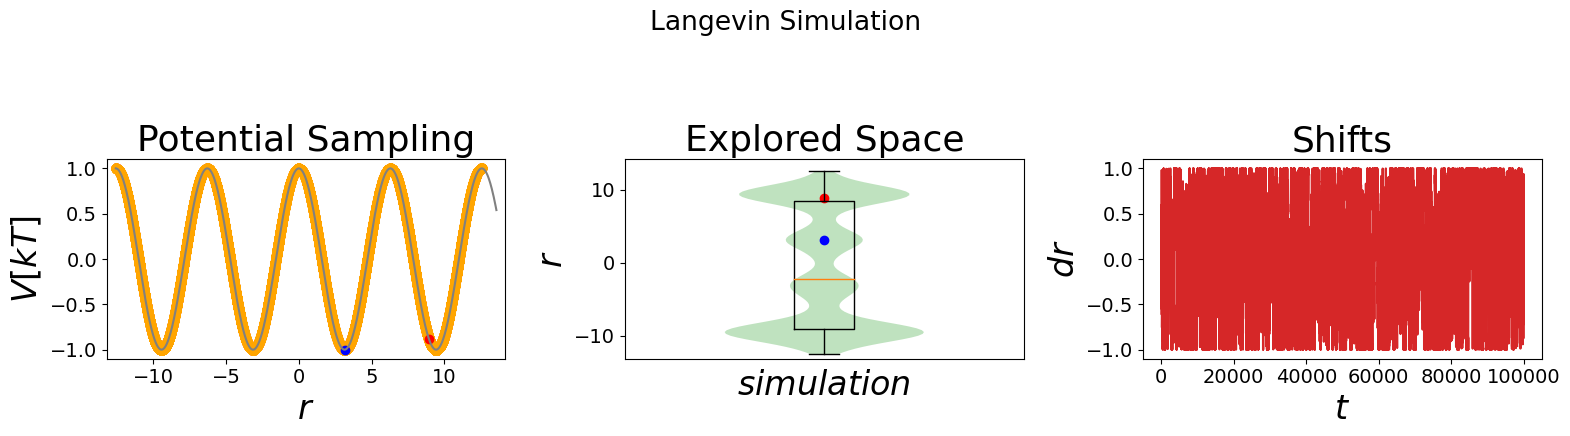

In [28]:
sampler = langevinIntegrator(dt=0.1, gamma=10)
periodic_cond = periodicBoundaryCondition(boundary=[min_x, max_x])
sys = system(potential=V, sampler=sampler, start_position=np.pi, temperature=1, conditions=[periodic_cond])

##Simulate
sys.simulate(steps=100000)

##Visualize
positions = np.linspace(start=min_x, stop=max_x, num=1000) #phase space to be visualized
oneD_simulation_analysis_plot(system=sys, title="Langevin Simulation", limits_coordinate_space=positions)

<div class="alert alert-warning">Please discuss the distribution of samples as function of r (=x) in the middle plot.<br>Please repeat the simulation a few times.</div>

***

### Function to transform MD samples into probability density 

In [29]:
def samples2density(xs, extent=extent, resolution=test_timing_with_points, slice_width=slice_width, dim=2):
    dx = np.power([slice_width], dim)

    min_x = extent[0]
    max_x = extent[1]

    # histogram: accumulate densities
    num_samples = xs.shape[0]
    #print(num_samples, xs.shape)
    if dim == 1:
        prob = np.zeros([resolution])
    elif dim == 2:
        prob = np.zeros(resolution, resolution)
    else:
        print("Analysis right now only for 1 or 2 dimensions")
    #print(xs[:20])
    if dim == 1:
        bins = resolution
        ranges = (min_x, max_x)
        #print(bins, ranges)
        prob, _ = np.histogram(xs, bins=bins, range=ranges, density=False)        
    elif dim == 2:
        bins = [resolution, resolution]
        ranges = [min_x, max_x, min_x, max_x]
        #print(bins, ranges)
        prob, _ = np.histogramdd(xs, bins=bins, range=ranges, density=False)
        
    prob = prob/num_samples 
    prob = prob/dx
    #print(torch.sum(prob))
    
    return prob    

### Function to compute thermodynamic properties based on computed density

In [30]:
def compute_stats_samples(energy, prob, slice_width=slice_width, dim=2):
    dx = np.power([slice_width], dim)

    av_en = np.mean(energy)

    prob_pos = prob[np.where(prob>0.0000001)]

    TS = -temperature*np.sum(prob_pos*np.log(prob_pos))*dx
    fe = av_en - TS

    
    return fe, av_en, TS

### Compute thermodynamic properties
First we convert the samples into probability density $p(x)$ with same bin width used for direct numerical integration over $x$ to obtain the thermodnamic properties.<br>
Next we compute average energy over all samples and entropy from $p(x)$.<br>
Finally the free energy is computed using $F = <E> - TS$.

In [33]:
prob_md = samples2density(sys.trajectory.position, resolution=test_timing_with_points, dim=1)
fe_md, av_en_md, ts_md = compute_stats_samples(sys.trajectory.total_potential_energy, prob_md, dim=1)


print("Average energy : % 8.3f (% 8.3f)" % (av_en_md, av_en))
print("Entropy        : % 8.3f (% 8.3f)" % (ts_md, ts))
print("Free energy    : % 8.3f (% 8.3f)" % (fe_md, fe))

#print(sys.trajectory.position)
#print(sys.trajectory.total_potential_energy)

Average energy :   -0.459 (  -0.446)
Entropy        :    2.900 (   3.013)
Free energy    :   -3.359 (  -3.459)


<div class="alert alert-warning">Dependent on the random seed of your simulation you may see good and not so good agreement with the ground truth.<br>Please discuss the following points:<br>
* In most cases the entropy from MD is smaller than the ground truth. Why is this the case?<br>
* Why do we not use numerical integration in the high dimensional case if it provides the correct solution?<br>
</div>

***

### Convergence
Finally we will do convergence analysis on all thermodynamic properties by dividing the MD trajectory into 100 consecutive blocks of frames $[1, 2, 3, ..., 100]$ and compute the quantities for blocks $i\in [1]$, $i\in [1,2]$, $i\in [1,2,3]$, ..., $i\in [1,2,3,...,100]$.
![Procedure of convergence analysis](ConvergenceAnalysis.PNG)

In [34]:
num_frames = sys.trajectory.total_potential_energy.shape[0]
num_steps_analysis = 100
num_frames_per_analysis = int(num_frames/num_steps_analysis)
print(num_frames, num_frames_per_analysis)

av_en_array = np.zeros(num_steps_analysis)
fe_array = np.zeros(num_steps_analysis)
ts_array = np.zeros(num_steps_analysis)

for i in range(num_steps_analysis):
    pot = sys.trajectory.total_potential_energy[:(i+1)*num_frames_per_analysis]
    pos = sys.trajectory.position[:(i+1)*num_frames_per_analysis]
    pro = samples2density(pos, resolution=test_timing_with_points, dim=1)
    fe_md, av_en_md, ts_md = compute_stats_samples(pot, pro, dim=1)
    fe_array[i] = fe_md
    av_en_array[i] = av_en_md
    ts_array[i] = ts_md

100001 1000


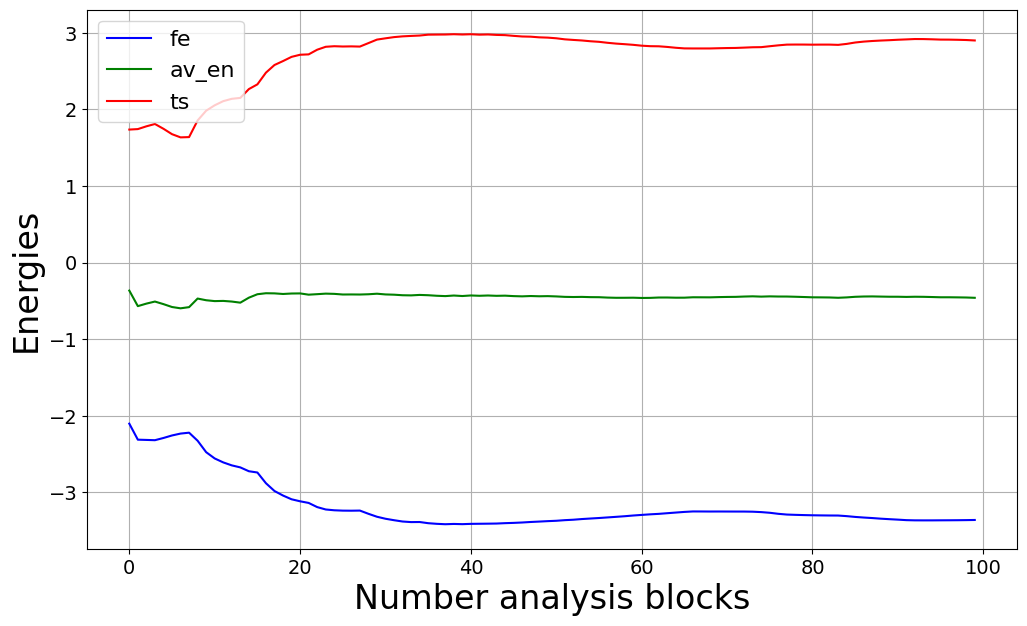

In [35]:
x = np.arange(0, num_steps_analysis, 1)

plt.plot(x, fe_array, label='fe', color='blue')
plt.plot(x, av_en_array, label='av_en', color='green')
plt.plot(x, ts_array, label='ts', color='red')

# Add labels and legend
plt.xlabel('Number analysis blocks')
plt.ylabel('Energies')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

<div class="alert alert-warning">Please compare the converence behavior of average energy, entropy and free energy.
</div>